In [1]:
################################################################################
# SETUP
################################################################################

# Convenience and saving flags
ABRIDGED_RUN = True
#ABRIDGED_RUN = False
SAVE_AFTER_TRAINING = True # Save the model when you are done
SAVE_CHECKPOINTS = True # Save the model after ever epoch
REPORT_TRAINING_LOSS_PER_EPOCH = True # Track the training loss each epoch, and write it to a file after training
REPORT_VALIDATION_LOSS_PER_EPOCH = True # Lets us make a nice learning curve after training

# Training hyperparameters
BATCH_SIZE = 256 # Number of samples per batch while training our network
NUM_EPOCHS = 60 # Number of epochs to train our network
LEARNING_RATE = 0.001 # Learning rate for our optimizer

# Directories
CHECKPOINT_DIR = "checkpoints/" # Checkpoints, models, and training data will be saved here
DATA_DIR = "../data/"
AUDIO_DIR = DATA_DIR + "train_audio/"
MODEL_NAME = None

# Preprocessing info
SAMPLE_RATE = 32000 # All our audio uses this sample rate
SAMPLE_LENGTH = 5 # Duration we want to crop our audio to
NUM_SPECIES = 182 # Number of bird species we need to label
MAX_SAMPLE_LENGTH = 60 # Trim every sample to <= 60 seconds
MIN_SAMPLE_LENGTH_NR = 10

In [3]:
################################################################################
# IMPORTS
################################################################################

# Basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import os
import IPython.display as ipd
import librosa
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
import noisereduce as nr

# Torch imports
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, random_split
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchaudio.transforms import MelSpectrogram, Resample
from IPython.display import Audio
import torch.optim as optim


/Users/junichikoganemaru/miniforge3/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
train = pd.read_csv(DATA_DIR + "train_metadata.csv")
train.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'primary_label', 'secondary_labels',
       'type', 'latitude', 'longitude', 'scientific_name', 'common_name',
       'author', 'license', 'rating', 'url', 'filename', 'duration',
       'channels', 'bitrate', 'sample_rate'],
      dtype='object')

In [32]:
################################################################################
# PREPROCESSING FUNCTIONS
################################################################################

# Transforms audio signal to a spectrogram
spectrogram_transform = torchaudio.transforms.Spectrogram(
        n_fft=2048,
        win_length=2048,
        hop_length=512,
        power=2
    )

# Converts ordinary spectrogram to Mel scale
mel_spectrogram_transform = torchaudio.transforms.MelScale(
    n_mels=256,
    sample_rate=SAMPLE_RATE,
    f_min=0,
    f_max=16000,
    n_stft=1025  # the number of frequency bins in the spectrogram
)

# Scales decibels to reasonable level (apply to a spectrogram or Mel spectrogram)
db_scaler = torchaudio.transforms.AmplitudeToDB(stype="power", top_db=80)

# Resizes spectrograms into square images
resize = transforms.Resize((224, 224), antialias = None)

# Applies a frequency mask to a spectrogram
def freq_mask(spec, F=30):
    num_mel_channels = spec.shape[1]
    f = random.randrange(0, F)
    f_zero = random.randrange(0, num_mel_channels - f)
    spec[:, f_zero:f_zero+f, :] = 0
    return spec

# Applies a time mask to a spectrogram
def time_mask(spec, T=40):
    spec_len = spec.shape[2]
    t = random.randrange(0, T)
    t_zero = random.randrange(0, spec_len - t)
    spec[:, :, t_zero:t_zero+t] = 0
    return spec

def noisereduce(audio):
    # if len(audio) <= MIN_SAMPLE_LENGTH_NR * SAMPLE_RATE:
    #     return audio 
    
    rms = librosa.feature.rms(y=audio, frame_length=SAMPLE_RATE * 1, hop_length=SAMPLE_RATE * 5)
    start = max(0,  np.argmin(rms) * SAMPLE_RATE * 5) 
    end = min(len(audio), start + SAMPLE_RATE * 1 ) 
    noise = audio[start:end]
    
    return nr.reduce_noise(y=audio, sr=SAMPLE_RATE, y_noise=noise)
    

In [13]:
# Takes a filepath and outputs a torch tensor that we can feed into our CNN
def filepath_to_tensor(filepath):
    sample, _ = torchaudio.load(filepath)
    if len(sample) >= SAMPLE_RATE * SAMPLE_LENGTH:
        sample = sample[:SAMPLE_RATE * SAMPLE_LENGTH]
    else:
        pad_length = SAMPLE_RATE * SAMPLE_LENGTH - len(sample)
        sample = torch.nn.functional.pad(sample, (0, pad_length))
    spec = spectrogram_transform(sample)
    mel_spec = mel_spectrogram_transform(spec)
    db_scaled_mel_spec = db_scaler(mel_spec)
    resized = resize(db_scaled_mel_spec)
    return resized

In [45]:
from torchgating import TorchGating as TG


# Takes a filepath and outputs a torch tensor that we can feed into our CNN
def filepath_to_tensor_noisereduced(filepath):
    sample, _ = torchaudio.load(filepath)
    tg = TG(sr=SAMPLE_RATE, nonstationary=True)
    sample = tg(sample)
    if len(sample) >= SAMPLE_RATE * SAMPLE_LENGTH:
        sample = sample[:SAMPLE_RATE * SAMPLE_LENGTH]
    else:
        pad_length = SAMPLE_RATE * SAMPLE_LENGTH - len(sample)
        sample = torch.nn.functional.pad(sample, (0, pad_length))
    spec = spectrogram_transform(sample)
    mel_spec = mel_spectrogram_transform(spec)
    db_scaled_mel_spec = db_scaler(mel_spec)
    resized = resize(db_scaled_mel_spec)
    return resized

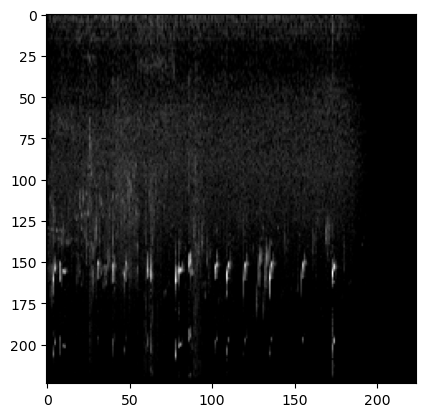

In [47]:
t = filepath_to_tensor(DATA_DIR+"train_audio/"+train.iloc[50]['filename'])
plt.imshow(t.squeeze().numpy(), cmap='gray')
plt.show()

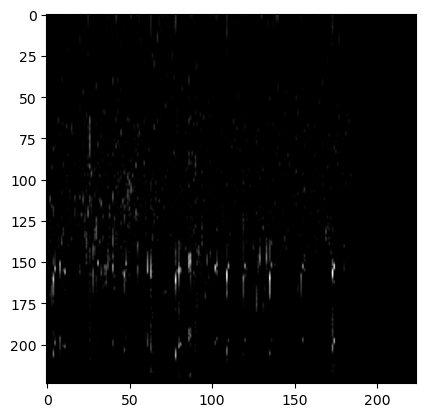

In [48]:
nr = filepath_to_tensor_noisereduced(DATA_DIR+"train_audio/"+train.iloc[50]['filename'])
plt.imshow(nr.squeeze().numpy(), cmap='gray')
plt.show()